In [1]:
import os
import random
import torch
from torchvision import transforms
from torchvision.io.image import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import OrderedDict

In [2]:
def sample_triplets(image_dir, num_triplets):
    dirnames = os.listdir(image_dir)
    triplets = set()

    while len(triplets) < num_triplets:
        # Randomly sample an anchor image
        anchor_dirname = random.choice(dirnames)
        anchor_filename = random.choice(os.listdir(os.path.join(image_dir, anchor_dirname)))
        anchor_path = os.path.join(image_dir, anchor_dirname, anchor_filename)

        # Randomly sample a positive image (same class as anchor)
        positive_dirname = anchor_dirname
        positive_dir_files = os.listdir(os.path.join(image_dir, positive_dirname))
        positive_dir_files.remove(anchor_filename)
        positive_filename = random.choice(positive_dir_files)
        positive_path = os.path.join(image_dir, positive_dirname, positive_filename)

        # Randomly sample a negative image (different class from anchor)
        dirnames_ = dirnames.copy()
        dirnames_.remove(anchor_dirname)
        negative_dirname = random.choice(dirnames_)
        negative_filename = random.choice(os.listdir(os.path.join(image_dir, negative_dirname)))
        negative_path = os.path.join(image_dir, negative_dirname, negative_filename)

        triplets.add((anchor_path, positive_path, negative_path))

    triplets = list(triplets)
    return triplets

In [3]:
class ImageTripletDataset(Dataset):
    def __init__(self, triplets, transform=None):
        self.triplets = triplets
        self.transform = transform

    def __getitem__(self, index):
        anchor_path, positive_path, negative_path = self.triplets[index]

        anchor_image = read_image(anchor_path, mode=ImageReadMode.RGB) / 255.0
        positive_image = read_image(positive_path, mode=ImageReadMode.RGB) / 255.0
        negative_image = read_image(negative_path, mode=ImageReadMode.RGB) / 255.0

        if self.transform is not None:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        return anchor_image, positive_image, negative_image

    def __len__(self):
        return len(self.triplets)

In [4]:
# Set the image directory and other parameters
image_dir = "dataset/CUB_200_2011/images"
num_triplets = 100
batch_size = 32

# Sample image triplets
triplets = sample_triplets(image_dir, num_triplets)

# Define the data transforms (CAN ADD OTHER TRANSFORMS, LIKE CROP, FLIP, ETC.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the image triplet dataset
dataset = ImageTripletDataset(triplets, transform=transform)

# Create the data loader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
triplets[45]

('dataset/CUB_200_2011/images/143.Caspian_Tern/Caspian_Tern_0010_145667.jpg',
 'dataset/CUB_200_2011/images/143.Caspian_Tern/Caspian_Tern_0115_145927.jpg',
 'dataset/CUB_200_2011/images/130.Tree_Sparrow/Tree_Sparrow_0128_123979.jpg')

In [6]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

# Define your dataset and data loaders for anchor, positive, and negative examples

# Define the triplet loss function
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # '''
        #  TODO: torch.dist computes frobenius norm, I want row-wise euclidean distance ! (CHANGE)
        # '''

        batch_size = anchor.shape[0]
        loss = torch.zeros(batch_size, dtype=torch.float32)

        for i in range(batch_size):
            distance_positive = torch.dist(anchor[i], positive[i], p=2)
            distance_negative = torch.dist(anchor[i], negative[i], p=2)
            loss[i] = torch.relu(distance_positive - distance_negative + self.margin)
        loss = torch.mean(loss)
        return loss

In [7]:
dims = 512

In [8]:
# Load the pretrained ResNet50 model
pretrained_model = resnet50(pretrained=True)

# Create the finetuning model with the pretrained backbone
finetuned_model = nn.Sequential(OrderedDict([*(list(pretrained_model.named_children())[:-1])]))
finetuned_model.add_module('fc', nn.Linear(2048, dims))
print(finetuned_model.fc)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
finetuned_model = finetuned_model.to(device)

for name, module in finetuned_model.named_children():
    print(name)

Linear(in_features=2048, out_features=512, bias=True)
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [18]:
# # Freeze the model parameters
# for name, param in finetuned_model.named_parameters():
#     if 'fc' in name:
#         print(name)
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias


In [9]:
def checkpoint(model, epoch):
    # Save model checkpoint
    print("Saving model checkpoint for epoch {}...".format(epoch))
    model_path = "../models/resnet50_finetuned_best.pth"
    torch.save(model, model_path)

In [19]:
# Define the triplet loss
triplet_loss = TripletLoss()

# Define the optimizer and learning rate scheduler
optimizer = optim.AdamW(finetuned_model.parameters(), lr=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# finetuned_model = torch.load("../models/resnet18_triplet_finetuned.pth")
# finetuned_model.to(device)
finetuned_model.train()

for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    min_loss = 1e6

    for anchor, positive, negative in dataloader:
        anchor = anchor.to(device)              # [3, 224, 224]
        positive = positive.to(device)
        negative = negative.to(device)

        optimizer.zero_grad()
        anchor_embedding = finetuned_model(anchor).flatten()       # [512, ]
        positive_embedding = finetuned_model(positive).flatten()
        negative_embedding = finetuned_model(negative).flatten()

        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        '''
            # In case the previous cell to freeze model params is run, 
            the next line must be uncommented to solve the error : 
            RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

            TODO: 
            On freezing model params for layers 6, 7 (both blocks of conv, batchnorm layers), 8 (Avg Pool), 
                the loss doesn't decrease at all!
        '''
        # loss.requires_grad = True #### (Only when freezing some model params)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if loss.item() < min_loss and epoch > 0:
        checkpoint(finetuned_model, epoch)
        min_loss = loss.item()   

    lr_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader)}")

# # Evaluate or save the finetuned model
# model_path = "../models/resnet18_triplet_finetuned.pth"
# torch.save(finetuned_model, model_path)

KeyboardInterrupt: 

: 

In [28]:
model_path = "../models/resnet18_finetuned_best.pth"
finetuned_model = torch.load(model_path)

Create a class dictionary to store mappings of class names with class ids

In [29]:
img_path = "dataset/CUB_200_2011/images/"
dir_list = os.listdir(img_path)
class_dict = {}
for dirname in dir_list:
    tokens = dirname.split(".")
    class_dict[tokens[1].lower()] = tokens[0]

class_dict

{'prothonotary_warbler': '177',
 'yellow_throated_vireo': '157',
 'prairie_warbler': '176',
 'cardinal': '017',
 'sooty_albatross': '003',
 'florida_jay': '074',
 'olive_sided_flycatcher': '040',
 'swainson_warbler': '178',
 'cape_glossy_starling': '134',
 'chestnut_sided_warbler': '165',
 'yellow_bellied_flycatcher': '043',
 'northern_waterthrush': '183',
 'ruby_throated_hummingbird': '068',
 'ringed_kingfisher': '082',
 'great_grey_shrike': '112',
 'parakeet_auklet': '007',
 'red_winged_blackbird': '010',
 'geococcyx': '110',
 'pine_warbler': '175',
 'white_eyed_vireo': '156',
 'field_sparrow': '119',
 'tropical_kingbird': '077',
 'nelson_sharp_tailed_sparrow': '126',
 'western_grebe': '053',
 'bewick_wren': '193',
 'mockingbird': '091',
 'brewer_sparrow': '115',
 'ring_billed_gull': '064',
 'house_sparrow': '118',
 'cedar_waxwing': '186',
 'indigo_bunting': '014',
 'herring_gull': '062',
 'grasshopper_sparrow': '121',
 'vesper_sparrow': '131',
 'seaside_sparrow': '128',
 'heermann_g

### Create CSV to store image file paths with corresponding bboxes

In [30]:
import pandas as pd

dataset_path = "dataset/CUB_200_2011"
imgs_path = dataset_path + "/images"
imgfile_path = dataset_path + "/images.txt"
bbox_path = dataset_path + "/bounding_boxes.txt"

df = pd.DataFrame(columns=['img_id', 'img_path', 'img_name', 'gx', 'gy', 'gw', 'gh', 'correct'])

with open(imgfile_path, 'r') as f:
    for line in f:
        line = line.strip('\n')
        l = line.split(' ')
        img_id, img_path = l
        df.loc[int(img_id)] = [int(img_id), imgs_path + "/" + img_path, img_path.split('/')[1], 0, 0, 0, 0, 0]

with open(bbox_path, 'r') as f:
    for line in f:
        line = line.strip('\n')
        l = line.split(' ')
        img_id, gx, gy, gw, gh = l
        df.loc[int(img_id), ['gx', 'gy', 'gw', 'gh']] = [gx, gy, gw, gh]

file_name = "dataset/CUB_200_2011/annotations_ft.csv"
df.to_csv(file_name, sep='\t', encoding='utf-8')

Next, compute embeddings for query and gallery images using the finetuned `resnet18` encoder.

In [31]:
from torchvision.transforms.functional import normalize, resize
import numpy as np

In [32]:
# function to compute the embeddings for each image in a input path using model defined above and save them in a output path
def compute_and_save_embeddings(inp_path : str, out_path : str):
    # create output directories
    os.makedirs(out_path + "/query", exist_ok=True)
    os.makedirs(out_path + "/gallery", exist_ok=True)

    query_path = inp_path + "/query"
    gallery_path = inp_path + "/gallery"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # compute embeddings for query images
    query_files = os.listdir(query_path)
    for file in query_files:
        img = read_image(query_path + "/" + file)
        input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)
        out = finetuned_model(input_tensor.unsqueeze(0))
        output_tensor = out.flatten()
        torch.save(output_tensor, out_path + "/query/" + file[:-4] + ".pt")

    # compute embeddings for gallery images
    gallery_dirnames = os.listdir(gallery_path)
    for dirname in gallery_dirnames:
        os.makedirs(out_path + "/gallery" + "/" + dirname, exist_ok=True)
        gallery_files = os.listdir(gallery_path + "/" + dirname)
        
        for file in gallery_files:
            img = read_image(gallery_path + "/" + dirname + "/" + file)
            input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)
            out = finetuned_model(input_tensor.unsqueeze(0))
            output_tensor = out.flatten() 
            torch.save(output_tensor, out_path + "/gallery/" + dirname + "/" + file[:-4] + ".pt")

In [33]:
img_path = "dataset/img_retrieval_CUB_200_2011"
emb_path = "embeddings_CUB_200_2011_ft"
compute_and_save_embeddings(img_path, emb_path)

/home/shreyas/anaconda3/envs/ets/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Finally, retrieve the saved embeddings, find the top-1 matched image using cosine similarity and save the heatmaps.

In [34]:
from image_ops import load_and_resize, pil_bgr_to_rgb, combine_image_and_heatmap
from similarity_ops import compute_spatial_similarity
import numpy as np
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
for name, param in finetuned_model.named_children():
    print(name)
    if name == '8':
        print(param)

0
1
2
3
4
5
6
7
8
AdaptiveAvgPool2d(output_size=(1, 1))


In [36]:
stylianou_model = nn.Sequential(*list(finetuned_model.children())[:-1])

In [37]:
for name, param in stylianou_model.named_children():
    print(name)
    if name == '7':
        print(param)

0
1
2
3
4
5
6
7
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchN

In [38]:
def stylianou(img1_path, img2_path, save_path): 
    '''
        Separate definition for CUB dataset, with only query-heatmap overlay as output.
    '''
    img1_filename = img1_path.split("/")[-1][:-4]
    img1 = read_image(img1_path)
    img2 = read_image(img2_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Preprocess
    img1_norm = normalize(resize(img1, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)
    img2_norm = normalize(resize(img2, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

    features1 = stylianou_model(img1_norm.unsqueeze(0))
    features2 = stylianou_model(img2_norm.unsqueeze(0))

    c, h, w = features1.squeeze(0).shape

    # Compute the similarity heatmap
    conv1 = features1.squeeze(0).permute(1, 2, 0).detach().cpu().numpy().reshape(h*w, c)
    conv2 = features2.squeeze(0).permute(1, 2, 0).detach().cpu().numpy().reshape(h*w, c)
    similarity = compute_spatial_similarity(conv1, conv2)

    similarity1, _ = similarity

    dummy_arr = np.zeros((224, 224, 3))

    img1_out = combine_image_and_heatmap(dummy_arr, similarity1)  # overlay heatmap on image

    overlay_img = img1_out[:, :, :3]
    sim_path = save_path + "/" + "{}.jpg".format(img1_filename)
    cv2.imwrite(sim_path, overlay_img)

In [39]:
# function to retrieve the query embeddings, compute the cosine similarity with all the gallery embeddings, return the top 1 results and save whether top-1 class matches or not
def retrieve_visualize(img_path : str, emb_path : str, vis_path: str, csv_path: str):
    # create output directories
    os.makedirs(vis_path, exist_ok=True)

    query_path = emb_path + "/query"
    gallery_path = emb_path + "/gallery"

    # retrieve and visualize query images
    df = pd.read_csv(csv_path, sep='\t', encoding='utf-8')
    
    query_files = os.listdir(query_path)
    for i, query_file in enumerate(query_files):
        query_emb = torch.load(query_path + "/" + query_file)
        gallery_dirnames = os.listdir(gallery_path)
        max_sim = -1
        max_file_path = ""
        for dirname in gallery_dirnames:
            file_names = os.listdir(gallery_path + "/" + dirname)
            for file in file_names:
                gallery_emb = torch.load(gallery_path + "/" + dirname + "/" + file)
                sim = torch.cosine_similarity(query_emb, gallery_emb, dim=0)
                if sim > max_sim:
                    max_sim = sim
                    max_file_path = dirname + "/" + file

        
        if i < 10 : print("Query : {} | Top reference : {}".format(query_file, max_file_path))

        correct = 0

        # save whether the retrieved image is of the correct class or not
        try:
            query_class = '_'.join(query_file[:-3].split('_')[:-2])
            query_class_id = int(class_dict[query_class.lower()])
            max_class = max_file_path.split('/')[0].split('.')[1]
            max_class_id = int(class_dict[max_class.lower()])

            
            if query_class_id == max_class_id:
                correct = 1

        except:
            pass

        query_imgname = query_file[:-3] + ".jpg"
        df.loc[df['img_name'] == query_imgname, 'correct'] = correct
        stylianou(img_path + "/query/" + query_file[:-3] + ".jpg", img_path + "/gallery/" + max_file_path[:-3] + ".jpg", vis_path)
    
    df.to_csv(csv_path, sep='\t', encoding='utf-8')

In [40]:
img_path = "dataset/img_retrieval_CUB_200_2011"
emb_path = "embeddings_CUB_200_2011_ft"
vis_path = "visualizations_CUB_200_2011_ft/heatmaps"
csv_path = "dataset/CUB_200_2011/annotations_ft.csv"
retrieve_visualize(img_path, emb_path, vis_path, csv_path)

Query : Western_Meadowlark_0120_77834.pt | Top reference : 101.White_Pelican/White_Pelican_0076_96427.pt


/home/shreyas/anaconda3/envs/ets/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Query : House_Wren_0130_187109.pt | Top reference : 070.Green_Violetear/Green_Violetear_0119_795724.pt
Query : Red_Breasted_Merganser_0064_79563.pt | Top reference : 067.Anna_Hummingbird/Anna_Hummingbird_0050_56794.pt
Query : Red_Headed_Woodpecker_0031_183096.pt | Top reference : 181.Worm_eating_Warbler/Worm_Eating_Warbler_0021_795545.pt
Query : Lincoln_Sparrow_0036_117280.pt | Top reference : 088.Western_Meadowlark/Western_Meadowlark_0019_77876.pt
Query : Red_Winged_Blackbird_0046_4242.pt | Top reference : 011.Rusty_Blackbird/Rusty_Blackbird_0082_6906.pt
Query : Pileated_Woodpecker_0015_180072.pt | Top reference : 124.Le_Conte_Sparrow/Le_Conte_Sparrow_0035_795214.pt
Query : Kentucky_Warbler_0040_795868.pt | Top reference : 185.Bohemian_Waxwing/Bohemian_Waxwing_0100_796627.pt
Query : Worm_Eating_Warbler_0055_795555.pt | Top reference : 021.Eastern_Towhee/Eastern_Towhee_0079_22690.pt
Query : Prairie_Warbler_0138_172695.pt | Top reference : 071.Long_tailed_Jaeger/Long_Tailed_Jaeger_0055_

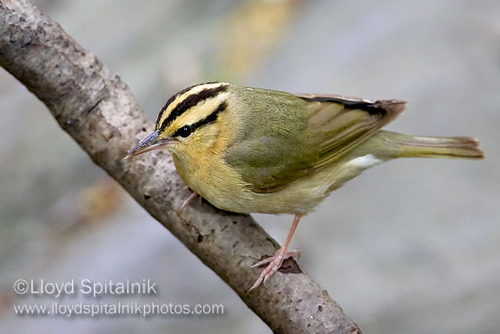

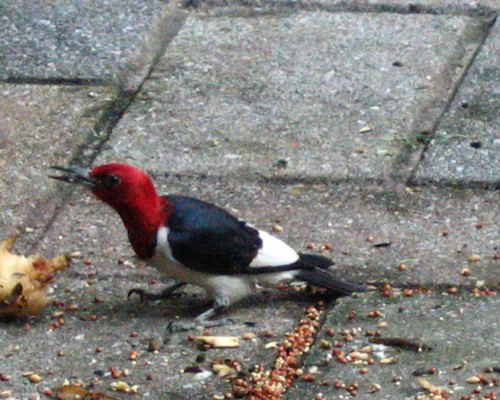

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

sample_query_path = "dataset/img_retrieval_CUB_200_2011/query/Red_Headed_Woodpecker_0031_183096.jpg"
sample_reference_path = "dataset/img_retrieval_CUB_200_2011/gallery/181.Worm_eating_Warbler/Worm_Eating_Warbler_0021_795545.jpg"

query_img = Image.open(sample_query_path)
ref_img = Image.open(sample_reference_path)

display(ref_img)
display(query_img)

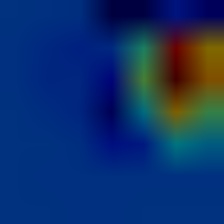

In [93]:
sample_hmap_path = "visualizations_CUB_200_2011_ft/heatmaps/Red_Headed_Woodpecker_0031_183096.jpg"

hmap_img = Image.open(sample_hmap_path)
display(hmap_img)

Next, compute bboxes from heatmaps using thresholding.

In [94]:
def compute_bboxes_from_heatmaps(hmap_path : str, img_path: str, vis_path: str, tau, area_frac):
    '''
        Function to compute bounding boxes from heatmaps, overlay them on images and store the bboxes and heatmaps.
    '''
    hmaps = os.listdir(hmap_path)
    for hmap_name in hmaps:
        bboxes = list()
        img_name = hmap_name
        # print(img_name)
        hmap = cv2.imread(hmap_path + "/" + hmap_name)
        hmap_cvt = cv2.cvtColor(hmap, cv2.COLOR_RGB2BGR)
        hmap_gray = cv2.cvtColor(hmap_cvt, cv2.COLOR_BGR2GRAY)

        hmap_thres = cv2.threshold(hmap_gray, tau * np.max(hmap_gray), 255, cv2.THRESH_BINARY_INV)[1]
        area_thres = area_frac * hmap_thres.shape[0] * hmap_thres.shape[1]

        cnts = cv2.findContours(hmap_thres.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        # (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
        img_arr = load_and_resize(img_path + "/{}".format(hmap_name))
        
        for c in cnts:
            if cv2.contourArea(c) < area_thres: continue
            x,y,w,h = cv2.boundingRect(c)
            bboxes.append([x, y, w, h])
            img_arr = cv2.rectangle(img_arr, (x, y), (x + w, y + h), (10, 255, 34), 2)
            
        cv2.imwrite(vis_path + "/overlayed/{}".format(hmap_name), img_arr)
        bboxes = np.array(bboxes)

        os.makedirs(vis_path + "/boxes", exist_ok=True)
        bbox_filename = hmap_name[:-4] + ".npy"
        np.save(vis_path + "/boxes/{}".format(bbox_filename), bboxes)

In [95]:
hmap_path = "visualizations_CUB_200_2011_ft/heatmaps"
img_path = "dataset/img_retrieval_CUB_200_2011/query"
vis_path = "visualizations_CUB_200_2011_ft/bboxes"
compute_bboxes_from_heatmaps(hmap_path, img_path, vis_path, tau=0.5, area_frac=0.1)

In [96]:
def compute_iou(bbox1, bbox2):
    '''
        Function to compute IoU between two bounding boxes.
    '''
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = w1 * h1
    boxBArea = w2 * h2

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [97]:
def resize_bboxes(bbox, w, h):
    '''
        Function to resize bounding boxes to original image size.
    '''
    x, y, bw, bh = bbox
    x = int(x / w * 224)
    y = int(y / h * 224)
    bw = int(bw / w * 224)
    bh = int(bh / h * 224)
    return [x, y, bw, bh]

In [98]:
def compute_box_acc(hmap_path : str, img_path: str, vis_path: str, csv_path : str, bbox_path : str, tau = 0.5, delta = 0.5, area_frac = 0.1, is_loc = False) -> float:
    '''
        Function to compute mean IoU between ground truth and predicted bounding boxes.
    '''

    # First, compute the bounding boxes from heatmaps
    compute_bboxes_from_heatmaps(hmap_path, img_path, vis_path, tau, area_frac)

    df = pd.read_csv(csv_path, sep='\t')
    bbox_names = os.listdir(bbox_path)
    mean_iou = 0
    for bbox_name in bbox_names:
        img_name = bbox_name[:-4] + ".jpg"
        gt_bbox_ = df[df['img_name'] == img_name][['gx', 'gy', 'gw', 'gh']].values[0]
        img = read_image(img_path + "/" + img_name)
        _, h, w = img.shape
        gt_bbox = resize_bboxes(gt_bbox_, w, h)
        pred_bboxes = np.load(bbox_path + "/" + bbox_name)

        max_iou = 0
        # max_pred_bbox = None
        for pred_bbox in pred_bboxes:
            if compute_iou(gt_bbox, pred_bbox) > max_iou: 
                max_iou = compute_iou(gt_bbox, pred_bbox)
                # max_pred_bbox = pred_bbox

        # if img_name == "Common_Raven_0128_102017.jpg":
        #     print(img_name)
        #     print(w, h)
        #     print(gt_bbox_, gt_bbox)
        #     print(max_pred_bbox)
        #     print(max_iou)

        correct = df.loc[df['img_name'] == img_name]['correct'].values[0]
        if is_loc:
            max_iou = 1 if max_iou > delta and correct == 1 else 0
        else:
            max_iou = 1 if max_iou > delta else 0
        mean_iou += max_iou
    return mean_iou / len(bbox_names)

In [102]:
hmap_path = "visualizations_CUB_200_2011_ft/heatmaps"
img_path = "dataset/img_retrieval_CUB_200_2011/query"
vis_path = "visualizations_CUB_200_2011_ft/bboxes"
csv_path = "dataset/CUB_200_2011/annotations_ft.csv"   
bbox_path = vis_path + "/boxes"

tau = 0.6
delta = 0.5
area_frac = 0.1
is_loc = False
compute_box_acc(hmap_path, img_path, vis_path, csv_path, bbox_path, tau, delta, area_frac, is_loc)

0.22

In [103]:
def compute_max_box_acc(hmap_path : str, img_path: str, vis_path: str, csv_path : str, bbox_path : str, delta = 0.5, area_frac = 0.1, is_loc = False, step = 0.05) -> float:
    max_tau, max_box_acc = 0, 0
    metric = "Top-1 Localization" if is_loc else "MaxBoxAcc"
    print("Computing {} for delta = {} ...".format(metric, delta))

    for tau in np.arange(0, 1, step):
        box_acc = compute_box_acc(hmap_path, img_path, vis_path, csv_path, bbox_path, tau, delta, area_frac, is_loc)
        print("tau = {}, BoxAcc = {}".format(tau, box_acc))
        if box_acc > max_box_acc:
            max_box_acc = box_acc
            max_tau = tau
    print("\n{} = {} at tau = {}".format(metric, max_box_acc, max_tau))    
    print("Re-computing results for tau = {} ... ".format(max_tau))
    compute_box_acc(hmap_path, img_path, vis_path, csv_path, bbox_path, max_tau, delta, area_frac)
    print("Done.")

In [104]:
delta = 0.5
area_frac = 0.1
is_loc = False
step = 0.05
compute_max_box_acc(hmap_path, img_path, vis_path, csv_path, bbox_path, delta, area_frac, is_loc, step)

Computing MaxBoxAcc for delta = 0.5 ...
tau = 0.0, BoxAcc = 0.0
tau = 0.05, BoxAcc = 0.0
tau = 0.1, BoxAcc = 0.0
tau = 0.15000000000000002, BoxAcc = 0.0
tau = 0.2, BoxAcc = 0.0
tau = 0.25, BoxAcc = 0.0
tau = 0.30000000000000004, BoxAcc = 0.01
tau = 0.35000000000000003, BoxAcc = 0.045
tau = 0.4, BoxAcc = 0.06
tau = 0.45, BoxAcc = 0.125
tau = 0.5, BoxAcc = 0.15
tau = 0.55, BoxAcc = 0.195
tau = 0.6000000000000001, BoxAcc = 0.22
tau = 0.65, BoxAcc = 0.24
tau = 0.7000000000000001, BoxAcc = 0.26
tau = 0.75, BoxAcc = 0.25
tau = 0.8, BoxAcc = 0.24
tau = 0.8500000000000001, BoxAcc = 0.215
tau = 0.9, BoxAcc = 0.225
tau = 0.9500000000000001, BoxAcc = 0.225

MaxBoxAcc = 0.26 at tau = 0.7000000000000001
Re-computing results for tau = 0.7000000000000001 ... 
Done.
